In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import matplotlib.cm as cm
import networkx.algorithms.community as nxcom
from community import community_louvain
import ipdb

In [3]:
def get_corr(data):
    data = np.array(q)
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    data = (data-data_mean) / data_std
    data_c = np.corrcoef(data)
    return data_c

In [4]:
randseed = 3
seg = pd.read_csv('./data/segement.csv', header=None)
raw0 = pd.read_csv(open('./data/id2000.csv'), header=0, index_col=0)
q = pd.read_csv('./data/q_20_aggragated.csv', index_col = 0)
b = pd.read_csv('./data/b_20_aggragated.csv', index_col = 0)  # time occupancy, (density)
raw0

,id2,lat,long,id,num_road,class
0,2001,116.42769,39.94485,HI7000d,4,0
1,2002,116.42764,39.94330,HI7001a,3,0
2,2003,116.42782,39.93705,HI7002a,2,0
3,2005,116.42832,39.92993,HI7039a,3,0
4,2006,116.42785,39.92513,HI7003a,3,0
...,...,...,...,...,...,...
202,61004,116.29400,39.97990,HI9037g,3,3
203,61005,116.29300,39.98990,HI9097c,3,3
204,61006,116.29000,39.99350,HI9098c,3,3
205,61007,116.28600,39.99870,HI9099c,3,3


In [5]:
q_det = q.T.mean()
b_det = b.T.mean()

In [6]:
nodes = np.array(raw0['id2'])

relation_df = pd.read_csv('./data/edges_all.csv', header = None)

In [7]:
relation_df['flow'] = ''

for i in range(len(relation_df)):
    #ipdb.set_trace()
    det1 = raw0[raw0['id2']==relation_df.iloc[i, 0]]['id'].iloc[0]
    det2 = raw0[raw0['id2']==relation_df.iloc[i, 1]]['id'].iloc[0]
    relation_df.iloc[i, 2] = (q_det[det1] + q_det[det2]) / 2

relation_df

,0,1,flow
0,2001,2002,467.753
1,2002,2003,346.658
2,2003,2005,290.099
3,2005,2006,394.707
4,2006,2007,431.022
...,...,...,...
235,61004,4045,398.524
236,61005,4043,439.801
237,61005,4045,375.032
238,61001,3051,263.398


In [8]:
relation = np.array(relation_df)
# relation

In [9]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(relation)  # add weight from flow

In [10]:
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 207 nodes.
We have 240 edges.


In [11]:
pos0 = raw0.iloc[:, 1:3]
pos0 = np.array(pos0)

In [12]:
vnode = pos0
npos = dict(zip(nodes, vnode))  # 获取节点与坐标之间的映射关系，用字典表示

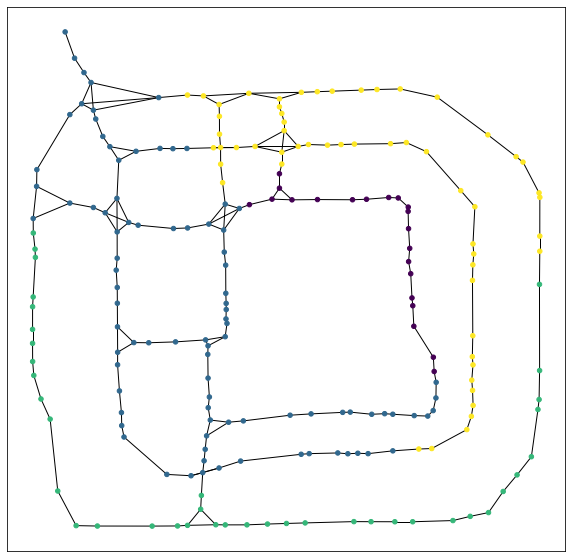

In [13]:
partition = community_louvain.best_partition(G, resolution=15, weight='weight', random_state=randseed)

# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

plt.figure(figsize = (10,10))
nx.draw_networkx(G, pos = npos, node_size=20, node_color=list(partition.values()), with_labels=False)
#plt.savefig('./res/img/%i_net'%randseed)

In [14]:
partition_results = pd.DataFrame(data = list(partition.values()))

In [15]:
partition_results['node'] = nodes

In [16]:
partition_results

,0,node
0,0,2001
1,0,2002
2,0,2003
3,0,2005
4,0,2006
...,...,...
202,1,61004
203,1,61005
204,1,61006
205,1,61007


In [17]:
partition_results.to_csv('./res/%i_partition_results1.csv'%randseed, index=False)

In [18]:
relation_df['if boundary nodes'] = ''

for i in range(len(relation_df)):
    class1 = partition_results[partition_results['node']==relation_df.iloc[i, 0]].iloc[0, 0]
    class2 = partition_results[partition_results['node']==relation_df.iloc[i, 1]].iloc[0, 0]
    if class1 != class2:
        relation_df.iloc[i, 3] = 1
    else:
        relation_df.iloc[i, 3] = 0

In [19]:
bound_nodes_df = relation_df[relation_df['if boundary nodes']==1].iloc[:, 0:2]
bound_nodes = np.array(bound_nodes_df).flatten()

In [20]:
bound_dets_df = pd.DataFrame([], columns=['n1d1','n1d2','n2d1','n2d2'], index=range(len(bound_nodes_df)))
for i in range(len(bound_nodes_df)):
    node1 = bound_nodes_df.iloc[i, 0]
    node2 = bound_nodes_df.iloc[i, 1]
    bound_dets_df.iloc[i, 0] = seg[seg[0]==node1].iloc[0, 6]
    bound_dets_df.iloc[i, 1] = seg[seg[0]==node1].iloc[0, 7]
    bound_dets_df.iloc[i, 2] = seg[seg[0]==node2].iloc[0, 6]
    bound_dets_df.iloc[i, 3] = seg[seg[0]==node2].iloc[0, 7]

In [21]:
bound_dets_df

,n1d1,n1d2,n2d1,n2d2
0,HI7010a,HI7009c,HI7011a,HI7010c
1,HI7054d,HI7032b,HI3002d,HI7033b
2,HI8011a,HI8057d,HI8058b,HI8012d
3,HI8038d,HI8037b,HI8039d,HI8066b
4,HI9071a,HI9033c,HI9033a,HI9034c
5,HI9038d,HI9073b,HI9039d,HI9038b
6,HI9055a,HI9054c,HI9056a,HI9055c
7,HI8020a,HI9078c,HI9079a,HI8020c
8,HI9061c,HI7032a,HI9062c,HI9061a
9,HI9082c,HI9081a,HI9083c,HI9082a


In [22]:
b_det = pd.DataFrame(b_det)
b_det['det'] = b_det.index
b_det['node']=''
b_det.index=range(402)

for i in range(len(b_det)):
    try:
        b_det.iloc[i, 2] = seg[seg[6]==b_det.iloc[i, 1]].iloc[0, 0]
    except:
        b_det.iloc[i, 2] = seg[seg[7]==b_det.iloc[i, 1]].iloc[0, 0]

b_det['class'] = ''
for i in range(len(b_det)):
    b_det.iloc[i, 3] = partition_results[partition_results['node']==b_det.iloc[i, 2]].iloc[0, 0]

In [23]:
for i in range(len(bound_nodes_df)):
    node1 = bound_nodes_df.iloc[i, 0]
    node2 = bound_nodes_df.iloc[i, 1]
    class1 = partition_results[partition_results['node']==node1].iloc[0, 0]
    class2 = partition_results[partition_results['node']==node2].iloc[0, 0]
    
    b1 = b_det[b_det['class']==class1]
    b2 = b_det[b_det['class']==class2]
    
    ini_var1 = np.var(np.array(b1[0]))  # initial variance 1
    ini_var2 = np.var(np.array(b2[0]))
    ini_mean1 = np.mean(np.array(b1[0]))
    ini_mean2 = np.mean(np.array(b2[0]))
    
    # 把node1从class1里面挑出来
    b1_ = b1[b1['node']!=node1][0]
    # 计算class1的variance
    var1 = np.var(np.array(b1_))
    # 把node1加到class2
    b2_ = np.append(np.array(b2[0]), np.array(b1[b1['node']==node1][0]))
    # 计算class2的variance
    var2 = np.var(b2_)
    # 比较两个variance，假如varianc减小，则保留更改，反之恢复原位
    if var1<ini_var1 and var2<ini_var2:
        b_det[b_det['node']==node1]['class'] = class2
        
    # 对node2重复以上五步
    b2_ = b2[b2['node']!=node2][0]
    var2 = np.var(np.array(b2_))
    b1_ = np.append(np.array(b1[0]), np.array(b2[b2['node']==node2][0]))
    var1 = np.var(b1_)
    if var1<ini_var1 and var2<ini_var2:
        b_det[b_det['node']==node2]['class'] = class1

C:\Users\10169\.conda\envs\dan_traff\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\10169\.conda\envs\dan_traff\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\10169\.conda\envs\dan_traff\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [24]:
b_det

,0,det,node,class
0,13.016764,HI2063a,3044,1
1,19.076875,HI2063c,3043,1
2,4.800302,HI2065a,3046,1
3,13.778998,HI2065c,3044,1
4,5.571532,HI2068a,2043,1
...,...,...,...,...
397,7.279762,HI9099c,61007,1
398,10.456748,HI9100a,61009,1
399,10.709316,HI9101c,61009,1
400,7.264045,HI9102a,61004,1


In [25]:
b_det.to_csv('./res/%i_b_det.csv'%randseed)

In [26]:
id_2000 = pd.read_csv('./data/id2000.csv', index_col=0)
id_402 = pd.read_csv('./data/selected_id.csv')
seg = pd.read_csv('./data/segement.csv', header=None)
partition_results = pd.read_csv('./res/%i_partition_results1.csv'%randseed)

id_402['id_node'] = ''
for i in range(len(id_402)):
    id_402.iloc[i, 4] = b_det[b_det['det']==id_402.iloc[i, 0]].iloc[0, 2]
        
id_402['class_i'] = ''
for i in range(len(id_402)):
    id_402.iloc[i, 5] = b_det[b_det['det']==id_402.iloc[i, 0]].iloc[0, 3]

id_402.to_csv('./res/%i_id_402_withclass.csv'%randseed)

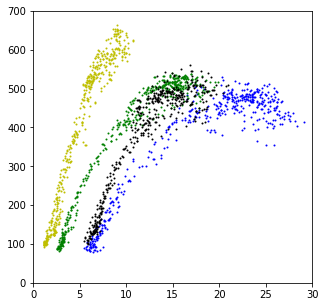

In [27]:
q = pd.read_csv('./data/q_20_aggragated.csv', index_col = 0)
b = pd.read_csv('./data/b_20_aggragated.csv', index_col = 0)  # time occupancy, (density)
v = pd.read_csv('./data/v_20_aggragated.csv', index_col = 0)
id_class = pd.read_csv('./res/%i_id_402_withclass.csv'%randseed)

id_class0 = id_class[id_class.class_i == 0]
q_c0 = q.loc[id_class0.id]
b_c0 = b.loc[id_class0.id]

id_class1 = id_class[id_class.class_i == 1]
q_c1 = q.loc[id_class1.id]
b_c1 = b.loc[id_class1.id]

id_class2 = id_class[id_class.class_i == 2]
q_c2 = q.loc[id_class2.id]
b_c2 = b.loc[id_class2.id]

id_class3 = id_class[id_class.class_i == 3]
q_c3 = q.loc[id_class3.id]
b_c3 = b.loc[id_class3.id]

id_class4 = id_class[id_class.class_i == 4]
q_c4 = q.loc[id_class4.id]
b_c4 = b.loc[id_class4.id]

id_class5 = id_class[id_class.class_i == 5]
q_c5 = q.loc[id_class5.id]
b_c5 = b.loc[id_class5.id]

fig = plt.figure(figsize=[5, 5])
ax2 = fig.add_subplot(111)
ax2.set_xlim([0, 30])
ax2.set_ylim([0, 700])

ax2.scatter(x = b_c0.iloc[:,:432].mean(), y = q_c0.iloc[:,:432].mean(), s=1, c = 'b')
ax2.scatter(x = b_c1.iloc[:,:432].mean(), y = q_c1.iloc[:,:432].mean(), s=1, c = 'g')
ax2.scatter(x = b_c2.iloc[:,:432].mean(), y = q_c2.iloc[:,:432].mean(), s=1, c = 'y')
ax2.scatter(x = b_c3.iloc[:,:432].mean(), y = q_c3.iloc[:,:432].mean(), s=1, c = 'black')
ax2.scatter(x = b_c4.iloc[:,:432].mean(), y = q_c4.iloc[:,:432].mean(), s=1, c = 'r')
ax2.scatter(x = b_c5.iloc[:,:432].mean(), y = q_c5.iloc[:,:432].mean(), s=1, c = 'grey')

#plt.savefig('./res/img/%i'%randseed)

# CH index (dont know the scale)

In [36]:
cluster_set = b_det['class'].drop_duplicates()

Nu1 = 0  # numerator 1
c = b_det[0].mean()
for c in cluster_set:
    cluster = b_det[b_det['class']==c]
    nk = len(cluster)
    ck = cluster[0].mean()
    Nu1 += nk*abs(ck-c)**2

Nu2 = 0  # numerator 2
for c in cluster_set:
    cluster = b_det[b_det['class']==c]
    nk = len(cluster)
    ck = cluster[0].mean()
    for i in range(nk):
        Nu2 += (cluster.iloc[i, 0] - ck)**2
        

CH = Nu1*Nu2/((len(cluster_set)-1) * (len(b_det)-len(cluster_set)))
CH

1125466.6348346474

## TV

In [43]:
cluster_set = b_det['class'].drop_duplicates()

TV = 0
for c in cluster_set:
    cluster = b_det[b_det['class']==c]
    NA = len(cluster)
    TV += NA*cluster[0].std()**2

TV

34979.43114461438